In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.utils import plot_model
from keras.preprocessing import image_dataset_from_directory, image
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Rescaling, RandomRotation, RandomZoom, RandomFlip, RandomContrast 
from keras.regularizers import l2
from keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping
from keras.models import load_model

2025-09-05 15:05:13.708887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757084714.052262      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757084714.149749      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
IMAGE_SIZE= 256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [6]:
## Uploading dataset
dataset_path = '/kaggle/input/teethdataset/Teeth_Dataset'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = dataset_path,           
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
)

Found 5144 files belonging to 3 classes.


In [25]:
# training dataset
train_path='/kaggle/input/teethdataset/Teeth_Dataset/Training'
train_data = train_data_gen.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical' 
)

Found 3087 images belonging to 7 classes.


In [26]:
#  validation dataset
val_path='/kaggle/input/teethdataset/Teeth_Dataset/Validation'
validation_data = validation_data_gen.flow_from_directory(
    val_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  
)

Found 1028 images belonging to 7 classes.


In [21]:
# testing dataset
test_path='/kaggle/input/teethdataset/Teeth_Dataset/Testing'
test_data = test_data_gen.flow_from_directory(
    '/kaggle/input/teethdataset/Teeth_Dataset/Testing',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 1028 images belonging to 7 classes.


In [22]:
class_names = dataset.class_names
class_names

['Testing', 'Training', 'Validation']

In [23]:
len(dataset)

161

In [13]:
176*32

5632

In [14]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape)
    print(labels_batch.numpy())

(256, 256, 3)
[1 1 1 1 0 1 1 1 1 2 1 0 0 0 1 1 2 2 1 1 1 0 2 1 1 2 1 1 1 1 1 1]


(256, 256, 3)


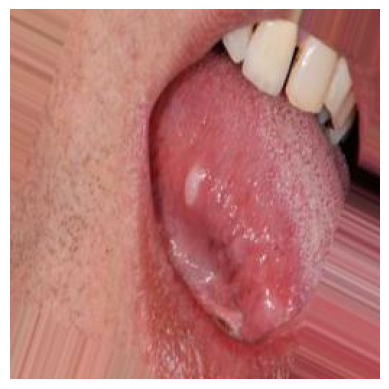

In [72]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape)
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    #plt.title(class_names[image_batch[0]])
    plt.axis("off")

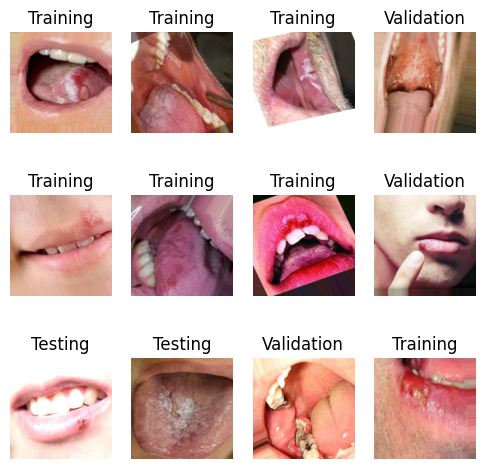

In [16]:
plt.figure(figsize=(6, 6))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [27]:
diseases = os.listdir(train_path)
print(f'Labels represent the following teeth diseases: {diseases}.')

Labels represent the following teeth diseases: ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP'].


In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(dataset, class_names=diseases, title='Training'):
    # labels 
    labels = dataset.classes   # (integers)
    unique, counts = np.unique(labels, return_counts=True)

    class_distribution = pd.DataFrame({
        'Class': [class_names[i] for i in unique],
        'Count': counts
    })

    plt.figure(figsize=(6, 3))
    sns.barplot(data=class_distribution, x='Class', y='Count', palette='magma', width=0.5)
    plt.title(f'{title} Set\'s Class Distribution')
    plt.xticks(rotation=45)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


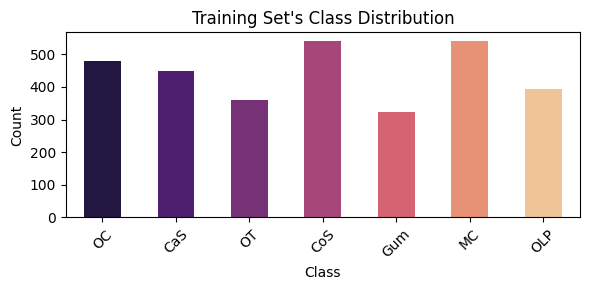

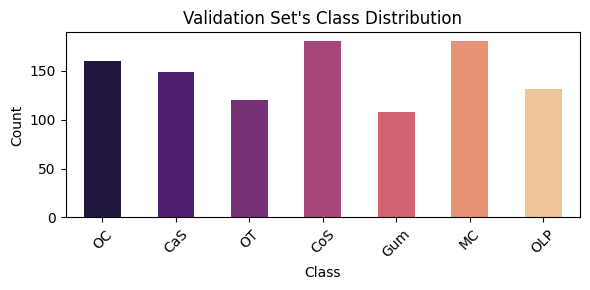

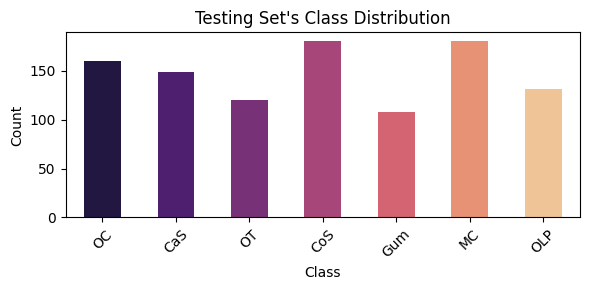

In [83]:
plot_class_distribution(dataset = train_data)
plot_class_distribution(dataset = validation_data, title = 'Validation')
plot_class_distribution(dataset = test_data, title = 'Testing')

## Building the model

In [31]:
#CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')  # 7 فئات
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,531,415 (360.61 MB)

 Trainable params: 31,510,471 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,020,944 (240.41 MB)

In [39]:
#  Compiling the Model
## We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(train_data, epochs=10, validation_data=validation_data)
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1757085051.956424      87 service.cc:148] XLA service 0x7eeedc001b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757085051.957839      87 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757085051.957862      87 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757085052.287111      87 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/97 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.1328 - loss: 10.6244

I0000 00:00:1757085057.574365      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 405ms/step - accuracy: 0.2027 - loss: 4.3037 - val_accuracy: 0.3239 - val_loss: 1.7700
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.4322 - loss: 1.5508 - val_accuracy: 0.4319 - val_loss: 1.5792
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.6585 - loss: 1.0105 - val_accuracy: 0.4912 - val_loss: 1.4487
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.8699 - loss: 0.4443 - val_accuracy: 0.5370 - val_loss: 1.5018
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9710 - loss: 0.1223 - val_accuracy: 0.5447 - val_loss: 1.7079
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.9892 - loss: 0.0561 - val_accuracy: 0.5263 - val_loss: 2.0186
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9981 - loss: 0.0180 - val_accuracy: 0.5700 - val_loss: 2.2166
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.5700 - val_loss: 

## Model Evaluation

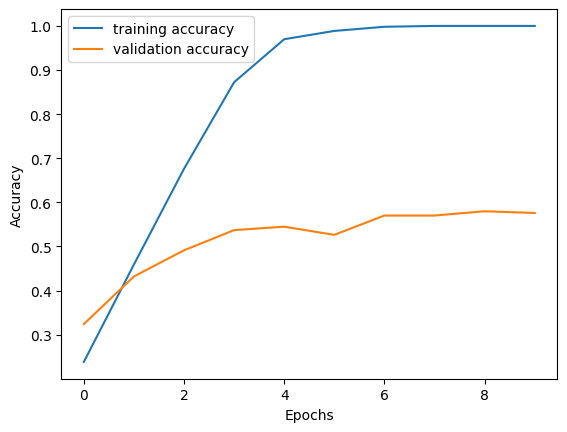

In [35]:
import matplotlib.pyplot as plt

## ploting model accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



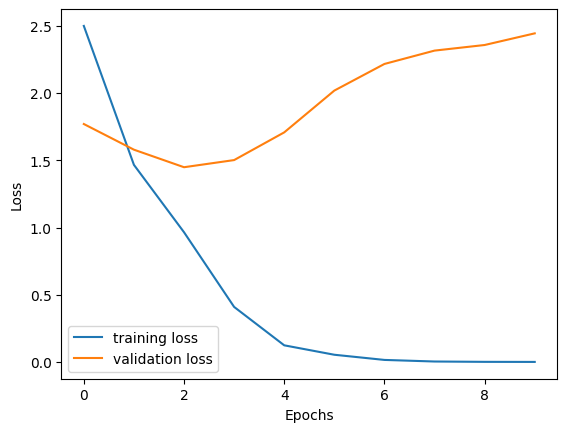

In [36]:
## ploting model loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
class_map = {i: name for i, name in enumerate(diseases)}
class_map


{0: 'OC', 1: 'CaS', 2: 'OT', 3: 'CoS', 4: 'Gum', 5: 'MC', 6: 'OLP'}

##  visualize some samples from test data and predict their label

In [63]:
def plot_act_vs_pred(model):
    images, labels = next(test_data)  
    predictions = model.predict(images)
    y_pred_classes = tf.argmax(predictions, axis=1).numpy()

    if len(labels.shape) > 1 and labels.shape[1] > 1:
        y_true_classes = tf.argmax(labels, axis=1).numpy()
    else:
        y_true_classes = labels  # integers

    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(25):
        image = (images[i] * 255).astype("uint8")
        true = diseases[y_true_classes[i]]
        pred = diseases[y_pred_classes[i]]
        color = 'green' if true == pred else 'red'
    
        axes[i].imshow(image)
        axes[i].set_title(f"True: {true}\nPred: {pred}", color=color, fontsize=9)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


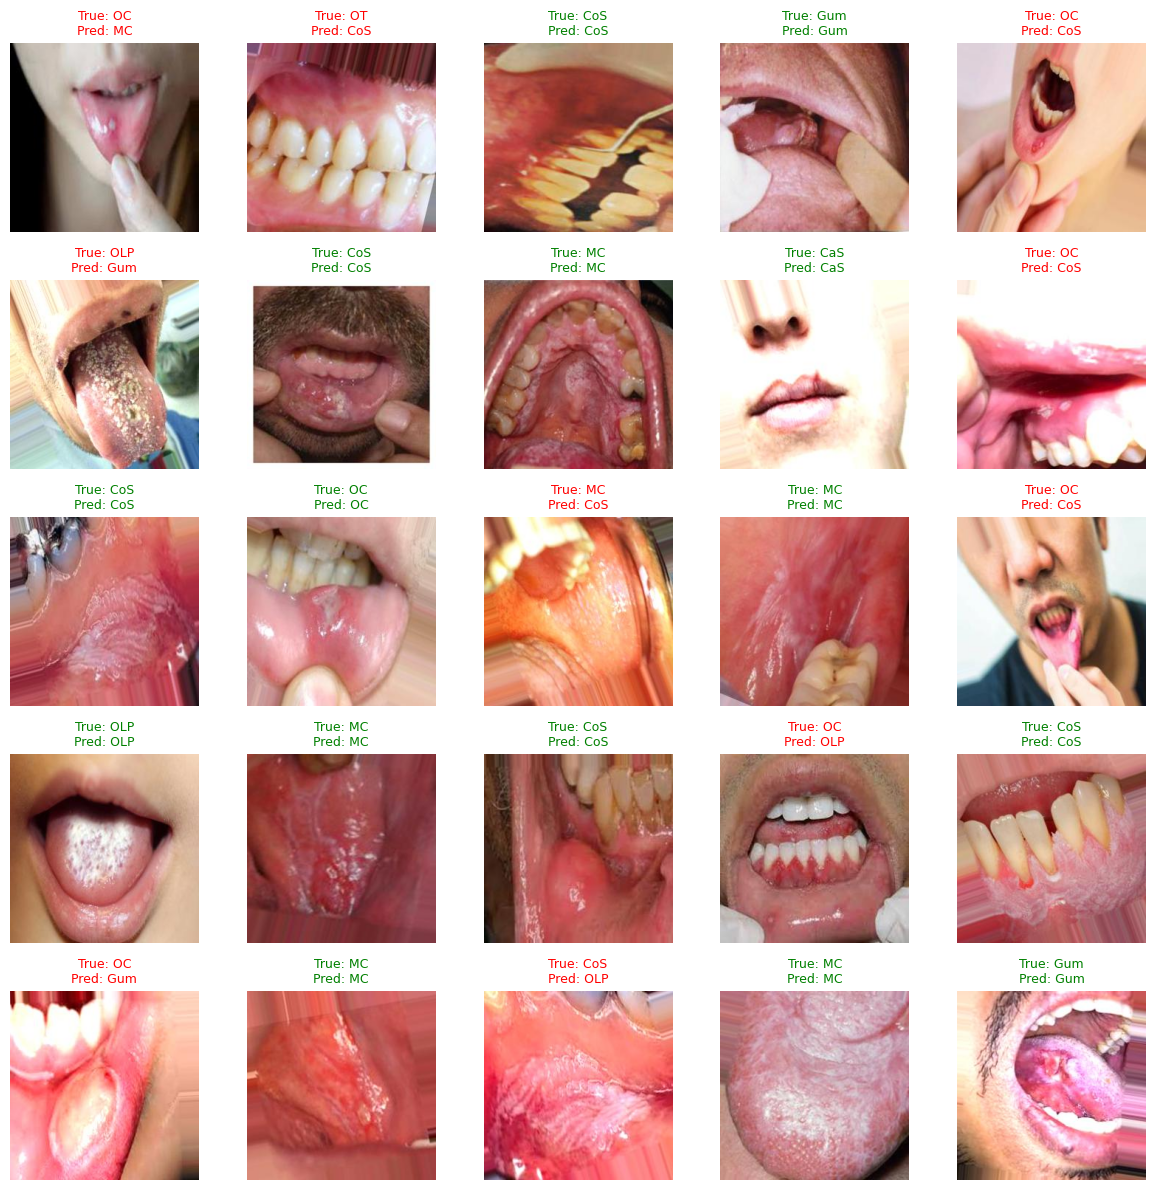

In [67]:
plot_act_vs_pred(model)

## Saving the Model

In [90]:
model.save('Model_Teeth_disease_classification.h5')